In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

In [4]:
# creating and cleaning dataset
h1=pd.read_csv('../data/H1.csv')
h2=pd.read_csv('../data/H2.csv')
h1.insert(0, 'Type', 'Resort Hotel')
h2.insert(0, 'Type', 'City Hotel')

h1_2=h1.append(h2)

hotel = h1_2.rename(columns = {'IsCanceled': 'Cxl', 'LeadTime': 'Lead time', 'ArrivalDateYear':'Arrival year',
                                   'ArrivalDateMonth':'Arrival month', 'ArrivalDateWeekNumber':'Arrival week number',
                                   'ArrivalDateDayOfMonth':'Arrival day of month',
                                   'StaysInWeekendNights':'Stays in weekend nights','StaysInWeekNights':'Stays in week nights', 'MarketSegment':'Market Segment',
                                   'DistributionChannel':'Distribution channel','IsRepeatedGuest':'Repeated guest', 
                                   'PreviousCancellations':'Previous cxl',
                                   'PreviousBookingsNotCanceled':'Previous not cxl rsv',
                                   'ReservedRoomType':'Rsv room type', 'AssignedRoomType':'Assigned room type',
                                   'BookingChanges':'Rsv changes',
                                   'DepositType':'Deposit type', 'DaysInWaitingList':'Days in wait list',
                                  'CustomerType': 'Customer type', 'RequiredCarParkingSpaces':'Parking',
                                   'TotalOfSpecialRequests':'Special requests', 'ReservationStatus':'Rsv status',
                                  'ReservationStatusDate':'Rsv status date'}, inplace = False)



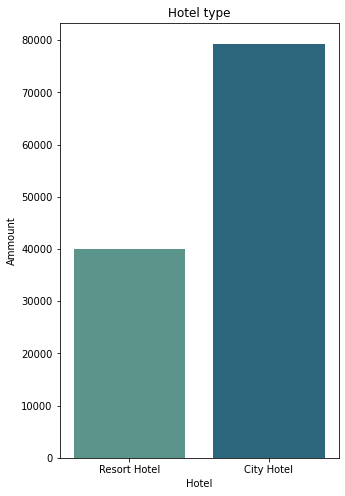

In [7]:
#total rsv by totel type
fig_hotel, ax_hotel = plt.subplots(figsize=(5,8))
sns.countplot(ax=ax_hotel, x='Type', data=hotel, palette="crest")
plt.title("Hotel type")
plt.xlabel("Hotel")
plt.ylabel('Ammount')


# Cancelations

In [8]:
# creating list to cettle order in graphs
lead_list=['Last minute','Less than a week','Less than a month','Less than 6 month','Less than a year','More than a year']

In [9]:
#choosing palette
sns.set_palette('RdYlGn')
palette_cxl = {"Check-Out": "C5", "No-Show": "C2", "Canceled":"C0"}

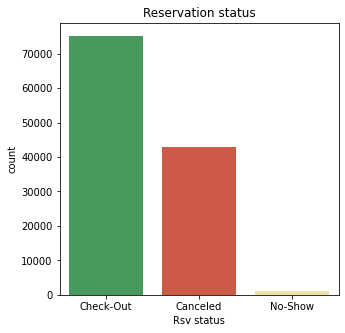

In [10]:
#total reservation status
fig_cxl, ax_cxl=plt.subplots(figsize=(5,5))
sns.countplot(ax=ax_cxl, x='Rsv status', data=hotel, palette=palette_cxl)
plt.title("Reservation status")



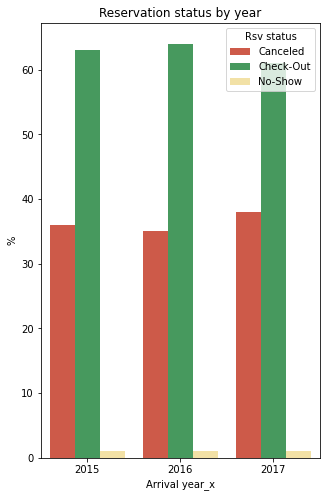

In [13]:
# Reservation status by year in %
year=hotel.groupby(['Rsv status', 'Arrival year'])['ADR'].count().reset_index()
year_total=hotel['Arrival year'].value_counts().reset_index().rename(columns={'index':'year'})

ty=year.merge(right=year_total, how="left",left_on="Arrival year", right_on="year")
percents_year=round(ty['ADR']/ty['Arrival year_y']*100)
ty['%'] = percents_year

fig_year, ax_year=plt.subplots(figsize=(5,8))
sns.barplot(ax=ax_year, x='Arrival year_x', y='%', hue='Rsv status', data=ty ,palette=palette_cxl)
plt.title("Reservation status by year")

#Cancelation tendancy keeps its level during years

Text(0.5, 1.0, 'Reservation status by hotel type')

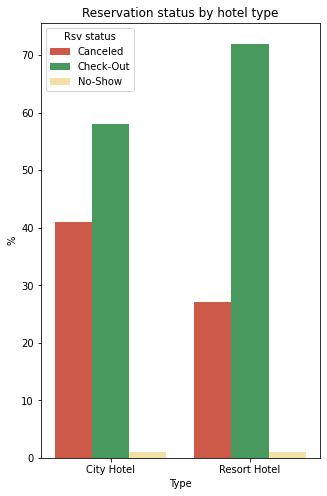

In [14]:
#rsv status by hotel type in %
type_status=hotel.groupby(['Type', 'Rsv status'])['ADR'].count().reset_index()
type_total=type_status.groupby(['Type']).sum().reset_index()
t=type_status.merge(right=type_total, how="left",left_on="Type", right_on="Type")
percents=round(t['ADR_x']/t['ADR_y']*100)
type_status['%'] = percents
type_status.rename(columns = {'ADR': 'Ammount'}, inplace = True)

plt.figure(figsize=(5,8))
sns.barplot(x='Type', y='%', hue='Rsv status', data=type_status,palette=palette_cxl)
plt.title("Reservation status by hotel type")
# Rsv status by hotel type. City hotel recives more cxl.

Text(0.5, 1.0, 'Time before arrival')

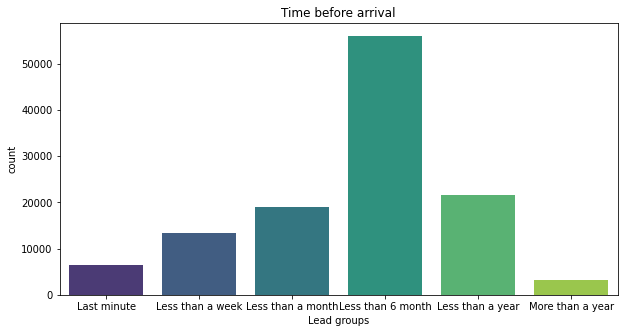

In [15]:
#typical lead tyme for hotels by type
#function to create lead groups
def lead_category (row):
    if row['Lead time'] == 0 :
        return 'Last minute'
    if row['Lead time'] >0 and row['Lead time'] <=7 :
        return 'Less than a week'
    if row['Lead time'] >7 and row['Lead time'] <=30 :
        return 'Less than a month'
    if row['Lead time'] >30 and row['Lead time']<= 180:
        return 'Less than 6 month'
    if row['Lead time'] >180 and row['Lead time']<= 365:
        return 'Less than a year'
    if row['Lead time'] >365 :
        return 'More than a year'
    
lead_groups=hotel.apply (lambda row: lead_category(row), axis=1)
hotel['Lead groups'] = lead_groups

plt.figure(figsize=(10,5))
sns.countplot(x='Lead groups', data=hotel, order=lead_list, palette="viridis")
plt.title("Time before arrival")
#most reservations are made between 1 and 6 month in advance

Text(0.5, 1.0, 'Time before arrival by Hotel vs Cancelation')

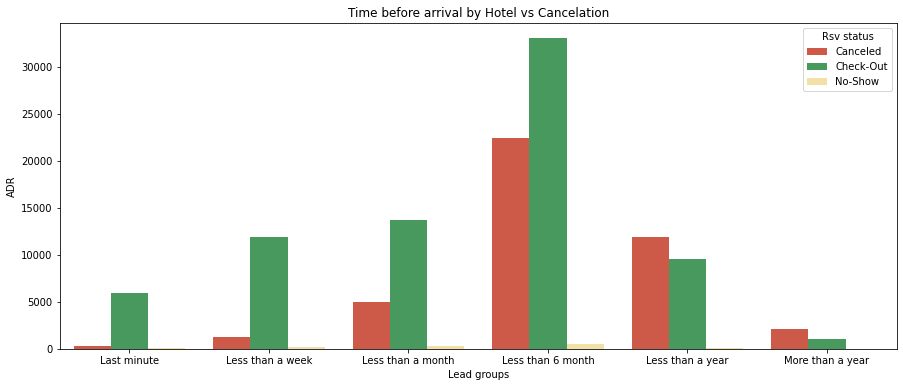

In [19]:
# lead time vs cxl
lead_vs_cxl=hotel.groupby(['Lead groups', 'Rsv status'])['ADR'].count().reset_index()

plt.figure(figsize=(15,6))
sns.barplot(x='Lead groups', y='ADR', hue='Rsv status', data=lead_vs_cxl, palette=palette_cxl, order=lead_list)

plt.title("Time before arrival by Hotel vs Cancelation")
#most % cxl are in reservation made in less than a year and more than a year in advance
# less - last minute rsvs

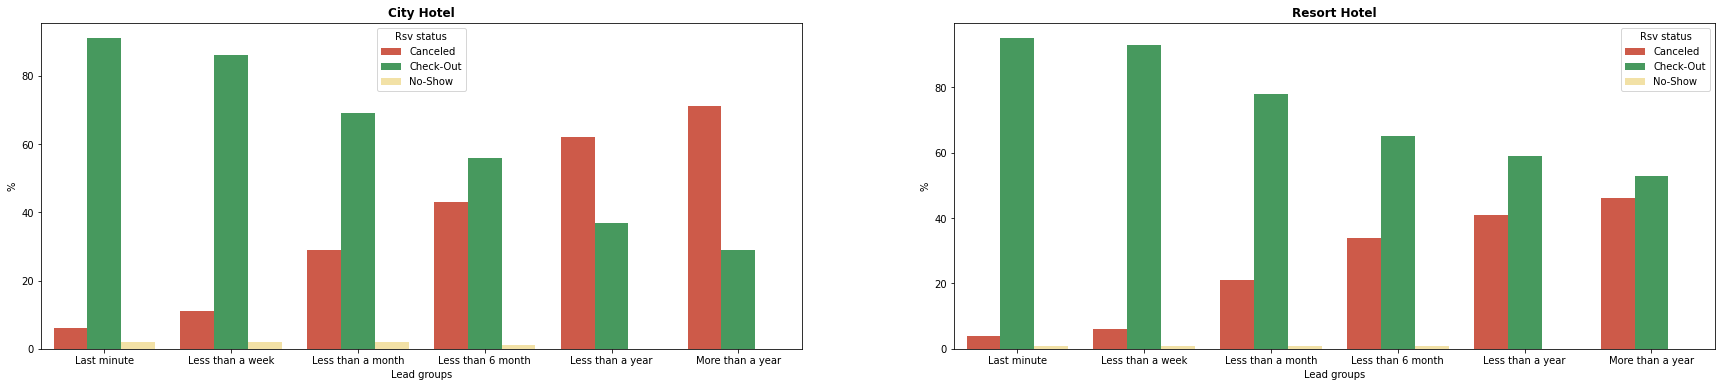

In [20]:
# lead time vs cxl by hotel type%
type_vs_lead_vs_cxl=hotel.groupby(['Type','Lead groups', 'Rsv status'])['ADR'].count().reset_index()
lead_total=type_vs_lead_vs_cxl.groupby(['Type','Lead groups']).sum().reset_index()

tl=type_vs_lead_vs_cxl.merge(right=lead_total, how="left",left_on=['Type','Lead groups'], right_on=['Type','Lead groups'])

percents_lead=round(tl['ADR_x']/tl['ADR_y']*100)
type_vs_lead_vs_cxl['%'] = percents_lead

city=type_vs_lead_vs_cxl[type_vs_lead_vs_cxl['Type']!='Resort Hotel']
resort=type_vs_lead_vs_cxl[type_vs_lead_vs_cxl['Type']=='Resort Hotel']

fig_2, ax_2 =plt.subplots(1,2,figsize=(30,6))
sns.barplot(data=city, x='Lead groups',y='%', hue='Rsv status', ax=ax_2[0],palette=palette_cxl, order=lead_list )
ax_2[0].set_title("City Hotel", weight='bold')
sns.barplot(data=resort, x='Lead groups',y='%', hue='Rsv status', ax=ax_2[1],palette=palette_cxl, order=lead_list)
ax_2[1].set_title("Resort Hotel", weight='bold')
#Lead time tendancy is true for both Hotels.

/usr/local/Cellar/jupyterlab/2.2.8/libexec/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

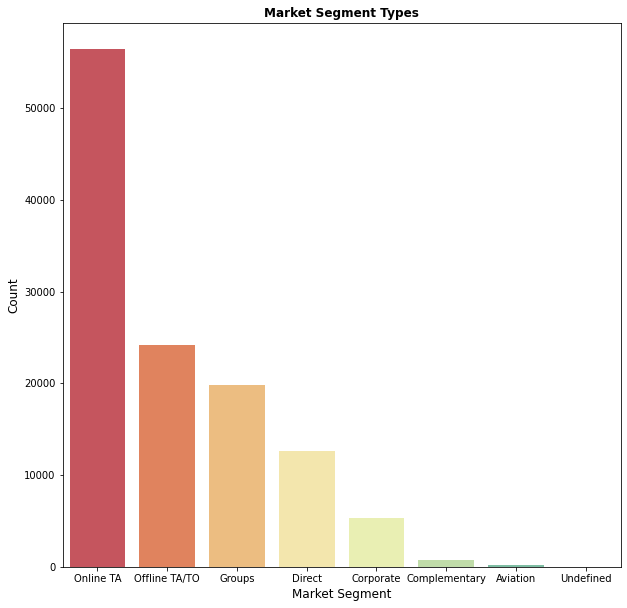

In [21]:
# Market segment

plt.figure(figsize=(10,10))
sns.countplot(hotel['Market Segment'], palette="Spectral", 
              order=pd.value_counts(hotel['Market Segment']).index)
plt.title('Market Segment Types', weight='bold')
plt.xlabel('Market Segment', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Most reservations are recived from Online TA

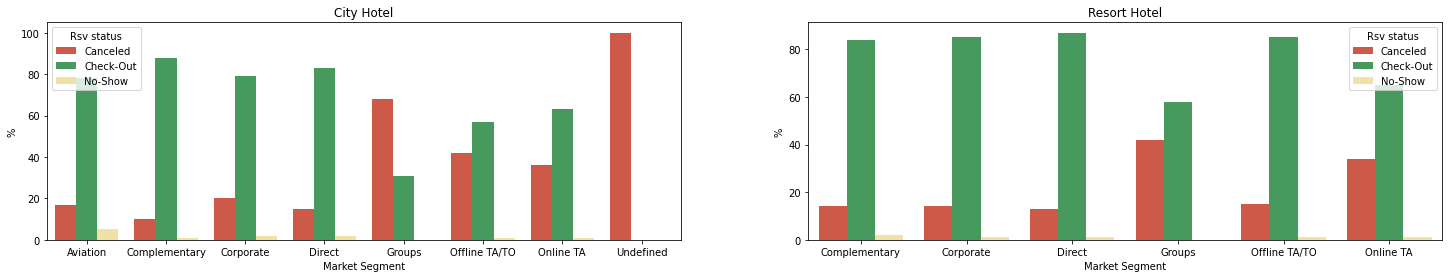

In [23]:
#cxl by Markrt Segment %
type_vs_segment_vs_cxl=hotel.groupby(['Type','Market Segment', 'Rsv status'])['ADR'].count().reset_index()
segment_total=type_vs_segment_vs_cxl.groupby(['Type','Market Segment']).sum().reset_index()

ts=type_vs_segment_vs_cxl.merge(right=segment_total, how="left",left_on=['Type','Market Segment'], right_on=['Type','Market Segment'])

percents_segment=round(ts['ADR_x']/ts['ADR_y']*100)
type_vs_segment_vs_cxl['%'] = percents_segment

city_segment=type_vs_segment_vs_cxl[type_vs_segment_vs_cxl['Type']!='Resort Hotel']
resort_segment=type_vs_segment_vs_cxl[type_vs_segment_vs_cxl['Type']=='Resort Hotel']

fig1_2, ax1_2 =plt.subplots(1,2,figsize=(25,4))
sns.barplot(data=city_segment, x='Market Segment',y='%', hue='Rsv status', ax=ax1_2[0],palette=palette_cxl )
ax1_2[0].set_title("City Hotel")
sns.barplot(data=resort_segment, x='Market Segment',y='%', hue='Rsv status', ax=ax1_2[1],palette=palette_cxl)
ax1_2[1].set_title("Resort Hotel")

#In spite of most reservations are recived from Online TA, most cxl are groups reservations.

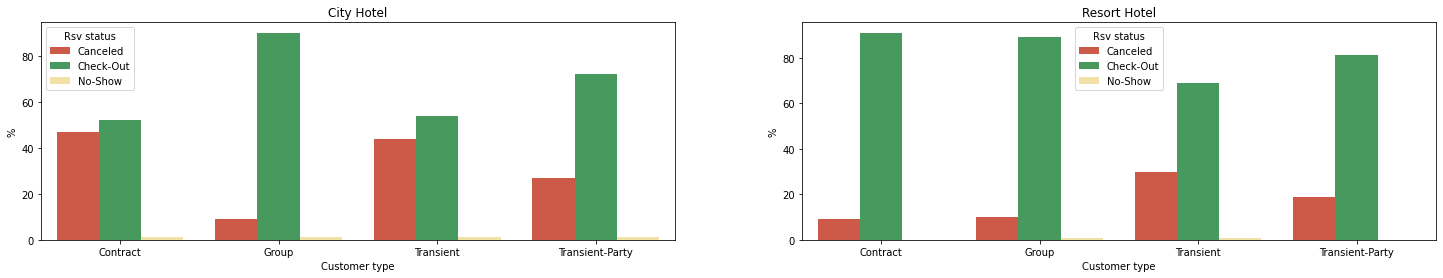

In [26]:
#customer type vs cxl in %
type_vs_customer_vs_cxl=hotel.groupby(['Type','Customer type', 'Rsv status'])['ADR'].count().reset_index()
customer_total=type_vs_customer_vs_cxl.groupby(['Type','Customer type']).sum().reset_index()
tc=type_vs_customer_vs_cxl.merge(right=customer_total, how="left",left_on=['Type','Customer type'], right_on=['Type','Customer type'])

percents_customer=round(tc['ADR_x']/tc['ADR_y']*100)

type_vs_customer_vs_cxl['%'] = percents_customer

city_customer=type_vs_customer_vs_cxl[type_vs_customer_vs_cxl['Type']!='Resort Hotel']
resort_customer=type_vs_customer_vs_cxl[type_vs_customer_vs_cxl['Type']=='Resort Hotel']

fig3_2, ax3_2 =plt.subplots(1,2,figsize=(25,4))
sns.barplot(data=city_customer, x='Customer type',y='%', hue='Rsv status', ax=ax3_2[0],palette=palette_cxl)
ax3_2[0].set_title("City Hotel")
sns.barplot(data=resort_customer, x='Customer type',y='%', hue='Rsv status', ax=ax3_2[1],palette=palette_cxl)
ax3_2[1].set_title("Resort Hotel")


# Statistical analysis

In [27]:
#function that creates leed samples
def lead_samples(row):
    if row['Lead time'] >=0 and row['Lead time'] <=30 :
        return 'Less than a month'
    if row['Lead time'] >30:
        return 'More than 1 month'

lead_samples_list=hotel.apply (lambda row: lead_samples(row), axis=1)
    
hotel['Lead samples'] = lead_samples_list



Text(0.5, 1.0, 'Lead samples')

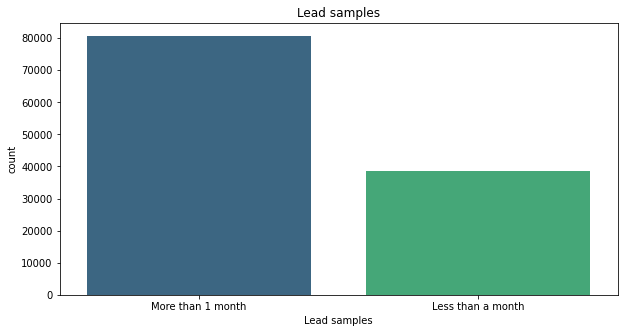

In [28]:
plt.figure(figsize=(10,5))
sns.countplot(x='Lead samples', data=hotel, palette="viridis")
plt.title("Lead samples")

In [29]:
hotel['Cxl'].value_counts()
cancelations=hotel[hotel['Cxl']==1]
cxl_samples=cancelations['Lead samples'].value_counts().sort_index()
rsv_total_samples=hotel['Lead samples'].value_counts().sort_index()

<AxesSubplot:>

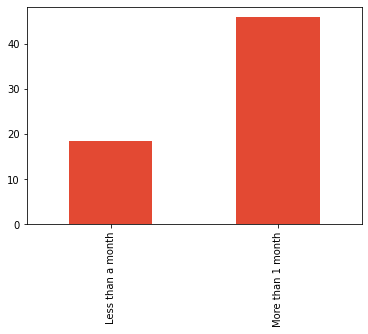

In [30]:
(cxl_samples*100/rsv_total_samples).plot.bar()
#the diffrence is statistical signicant

In [31]:
proportions_ztest(cxl_samples,rsv_total_samples)
#one sampleis greater than an other. Null hypothesis is rejected

(-91.57502496693074, 0.0)

In [32]:
def segment_samples(row):
    if row['Market Segment'] =='Online TA':
        return 'Online segment'
    if row['Market Segment'] !='Online TA':
        return 'Offline segment'

In [33]:
segment_samples_list=hotel.apply (lambda row: segment_samples(row), axis=1)
hotel['Segment samples'] = segment_samples_list
cancelations=hotel[hotel['Cxl']==1]
cxl_samples_segment=cancelations['Segment samples'].value_counts().sort_index()
segment_total_samples=hotel['Segment samples'].value_counts().sort_index()

<AxesSubplot:>

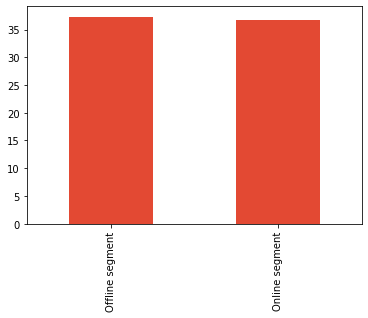

In [34]:
(cxl_samples_segment*100/segment_total_samples).plot.bar()

In [35]:
proportions_ztest(cxl_samples_segment,segment_total_samples)
#one sampleis greater than an other. Null hypothesis is rejected
# online cxl are less than ofline and this 

(2.1726297904702148, 0.02980819187485283)